<a href="https://colab.research.google.com/github/varJATIN/Ocular-fundus-image-Analysis/blob/main/Optic_disk_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import sys
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

from sklearn.utils import shuffle
from matplotlib.pyplot import imread
from cv2 import resize
import matplotlib.pyplot as plt
import cv2
import scipy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g6QeO2O6i2j0LzRYA0vwZZa3pSRe-ehJIrw57rnuxTG0vbrO3W6bRc
Mounted at /content/drive


In [4]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c=tf.keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c=tf.keras.layers.BatchNormalization()(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def atten(x,g,F_x,F_g,F_int,kernel_size=(3,3), padding="same", strides=1):
    # upsample lower decoder filters
    us = keras.layers.UpSampling2D((2, 2))(g)
    gate = keras.layers.Conv2D(F_g, kernel_size, padding=padding, strides=strides, activation="relu")(us)
    gate=tf.keras.layers.BatchNormalization()(gate)
    
    # convolve the upsampled decoder filter for F_int filters
    W_g=keras.layers.Conv2D(F_int, kernel_size=1, padding=padding, strides=strides)(gate)
    W_g=tf.keras.layers.BatchNormalization()(W_g)
    
    # convolve encoder output for F_int filters
    W_x=keras.layers.Conv2D(F_int, kernel_size=1, padding=padding, strides=strides)(x)
    W_x=tf.keras.layers.BatchNormalization()(W_x)
    
    # convolve to  attention filter
    psi=tf.keras.activations.relu(W_x+W_g, alpha=0.0, max_value=None, threshold=0)
    psi=keras.layers.Conv2D(F_x, kernel_size=1, padding=padding, strides=strides)(psi)
    psi=tf.keras.activations.sigmoid(tf.keras.layers.BatchNormalization()(psi))
    
    # return the filtered encoder output for concat
    return x*psi

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    us = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(us)
    us = tf.keras.layers.BatchNormalization()(us)
    # here skip is from encoder and x if from dec previous layer 
    filtered_skip=atten(skip,x,filters,filters,filters/2)
    #concat filtrd skip and upsampled us
    concat = keras.layers.Concatenate()([us, filtered_skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c=tf.keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c=tf.keras.layers.BatchNormalization()(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c=tf.keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c=tf.keras.layers.BatchNormalization()(c) 
    return c

In [5]:
def UNet_modular(depth=4,f=3,image_size=512):
    """ returns a modular code for the UNet multihead attention with
        deep supervision.
        depth is depth of model excluding bottleneck.
        f is no of filters in first layer.
        image_size is image pixel 
    """
    # define input container with 3 input channels
    input_channels=3
    inputs= keras.layers.Input((image_size, image_size, input_channels))
    pooled_out=inputs
    skip_memory=[]
    filters=[]
    for layer in range(depth):
      filters.append(f*2**layer)
    print(filters)

    for layer in range(depth):
      x,pooled_out=down_block(pooled_out,filters[layer])
      skip_memory.append(x)	

    # bottleneck_factor 
    bn_factor=2**depth
    upsample_out=bottleneck(pooled_out,f*bn_factor)
    upsample_memory=[upsample_out]
    for layer in range(depth):
      upsample_out=up_block(upsample_out,skip_memory[depth-1-layer],filters[depth-1-layer])
      upsample_memory.append(upsample_out)

    #up sample layer
    up=keras.layers.UpSampling2D((2,2))
    #create empty list for storing skip up samples 
    skip_up_list=[]
    # upsample the outputs of upsample layers stored in upsample_memory
    for i in range(depth):
      skip_up=upsample_memory[i]
      for j in range(depth-i):
        skip_up=up(skip_up)
      skip_up_list.append(skip_up)
    skip_up_list.append(upsample_memory[depth])
    deep_supervised = keras.layers.Concatenate()(skip_up_list)
    outputs=keras.layers.Conv2D(1,(1,1),padding="same",activation="sigmoid")(deep_supervised)
    model=keras.models.Model(inputs,outputs)
    return model

In [6]:
from sklearn.utils import shuffle
from matplotlib.pyplot import imread
from cv2 import resize
import matplotlib.pyplot as plt
import cv2

In [7]:
# data
data_location = "/content/drive/My Drive/IDRid/A. Segmentation/1. Original Images/a. Training Set"
train_data = []  # create an empty list
for (dirName, subdirList, fileList) in sorted(os.walk(data_location)):
    for fileName in sorted(fileList):
        if ".jpg" in fileName.lower() :
            train_data.append(os.path.join(dirName,fileName))
 
print(len(train_data))

54


In [8]:

# groundtruths for hard exudates
target_root_location = "/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/"
#data_location = "/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/3. Hard Exudates"
train_data_gt = []  # create an empty list
segs=['5. Optic Disc']
for seg in segs:
  data_location=target_root_location+seg
  print(data_location)
  seg_mask=[]
  for dirName, subdirList, fileList in sorted(os.walk(data_location)):
      for filename in sorted(fileList):
          if ".tif" in filename.lower() :
              seg_mask.append(os.path.join(dirName,filename))
              #train_data_gt.append(os.path.join(dirName,filename))
  train_data_gt.append(seg_mask)
print(len(train_data_gt));

/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/5. Optic Disc
1


In [9]:
# data
data_location = "/content/drive/My Drive/IDRid/A. Segmentation/1. Original Images/b. Testing Set"
test_data = []  # create an empty list
for (dirName, subdirList, fileList) in sorted(os.walk(data_location)):
    for fileName in sorted(fileList):
        if ".jpg" in fileName.lower() :
            test_data.append(os.path.join(dirName,fileName))  

# groundtruths for hard exudates
target_root_location = "/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/"
#data_location = "/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/3. Hard Exudates"
test_data_gt = []  # create an empty list1
segs=['5. Optic Disc']
for seg in segs:
  data_location=target_root_location+seg
  print(data_location)
  seg_mask=[]
  for dirName, subdirList, fileList in sorted(os.walk(data_location)):
      for filename in sorted(fileList):
          if ".tif" in filename.lower() :
              seg_mask.append(os.path.join(dirName,filename))
              #train_data_gt.append(os.path.join(dirName,filename))
  test_data_gt.append(seg_mask)
print(len(test_data_gt)); 

/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/5. Optic Disc
1


In [11]:
def crop_image_from_gray(img, tol=8):
    # If for some reason we only have two channels
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    # If we have a normal RGB images
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img,mask
def preprocess_image(image,label, sigmaX=8):
    IMG_WIDTH=512
    image,mask = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_WIDTH, IMG_WIDTH))
    #print(image.shape,label.shape)
    image = cv2.addWeighted (image,4, cv2.GaussianBlur(image, (0,0) ,sigmaX), -4, 128)
    label = label[:,:][np.ix_(mask.any(1),mask.any(0))]
    return image,label

## train data

In [14]:
train_batch = np.zeros(shape = (len(train_data)*5, 512, 512, 3));
train_label = np.zeros(shape = (len(train_data)*5, 512, 512, 1));
rot=[-4,-3,-2,-1,1,2,3,4]

for file_index in range(0,len(train_data)*5,5):
    #print(file_index)
    # image
    img=imread(train_data[int(file_index/5)])
     # label
    lbl = cv2.cvtColor(imread(train_data_gt[0][int(file_index/5)]), cv2.COLOR_BGRA2BGR)
    lbl = cv2.cvtColor(lbl, cv2.COLOR_BGR2GRAY) 
    #print(img.shape,lbl.shape)
    img,lbl=preprocess_image(img,lbl)
    train_batch[file_index, :, :,:],train_label[file_index, :, :,:]  = img,np.expand_dims(resize(lbl, (512, 512)), axis = 2)
    #flip
    train_batch[file_index+1, :, :,:]=np.flip(train_batch[file_index, :, :,:],axis=1)
    train_label[file_index+1, :, :,:]=np.flip(train_label[file_index, :, :,:],axis=1)
    #flip
    train_batch[file_index+2, :, :,:]=np.flip(train_batch[file_index, :, :,:],axis=0)
    train_label[file_index+2, :, :,:]=np.flip(train_label[file_index, :, :,:],axis=0)
    #rotate
    train_batch[file_index+3, :, :,:]=np.rot90(np.rot90(train_batch[file_index, :, :,:]))
    train_label[file_index+3, :, :,:]=np.rot90(np.rot90(train_label[file_index, :, :,:]))

    #random rotate
    ang=random.choice(rot)
    train_batch[file_index+4, :, :,:]=scipy.ndimage.rotate(train_batch[file_index, :, :,:],ang,reshape=False)
    train_label[file_index+4, :, :,:]=scipy.ndimage.rotate(train_label[file_index, :, :,:],ang,reshape=False)


train_batch[:,:,:,0]  = (train_batch[:,:,:,0])/255# - train_images[:,:,:,0].min(axis=0)) / (train_images[:,:,:,0].max(axis=0) - train_images[:,:,:,0].min(axis=0)+1e-10)
train_batch[:,:,:,1]  = (train_batch[:,:,:,1])/255# - train_images[:,:,:,1].min(axis=0)) / (train_images[:,:,:,1].max(axis=0) - train_images[:,:,:,1].min(axis=0)+1e-10)
train_batch[:,:,:,2]  = (train_batch[:,:,:,2])/255# - train_images[:,:,:,2].min(axis=0)) / (train_images[:,:,:,2].max(axis=0) - train_images[:,:,:,2].min(axis=0)+1e-10)

train_label  = train_label / np.max(train_label)
mask = train_label[:,:,:,:] > 0.3
train_label[mask] = 1.0
train_label[~mask] = 0.0

print(train_batch.shape)
print(train_label.shape)

(270, 512, 512, 3)
(270, 512, 512, 1)


## test data

In [15]:
test_batch = np.zeros(shape = (len(test_data), 512, 512, 3));
#test_labels_ls=[]
test_label = np.zeros(shape = (len(test_data), 512, 512, 1));

for file_index in range(0,len(test_data)):
    #print(file_index)
    # image
    img=imread(test_data[int(file_index)])
    # label
    lbl = cv2.cvtColor(imread(test_data_gt[0][int(file_index)]), cv2.COLOR_BGRA2BGR)
    lbl = cv2.cvtColor(lbl, cv2.COLOR_BGR2GRAY) 
    img,lbl=preprocess_image(img,lbl)
    test_batch[file_index, :, :,:],test_label[file_index, :, :,:]  = img,np.expand_dims(resize(lbl, (512, 512)), axis = 2)
    #flip
    
test_batch  = test_batch/255
test_label  = test_label / np.max(test_label)

mask = test_label[:,:,:,:] > 0.3
test_label[mask] = 1.0
test_label[~mask] = 0.0

print(test_batch.shape)
print(test_label.shape)

(27, 512, 512, 3)
(27, 512, 512, 1)


In [16]:
from keras import backend as K
def dice_loss(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return 1-dice

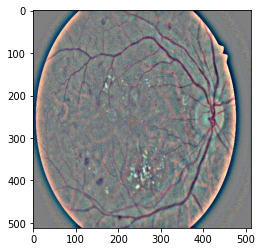

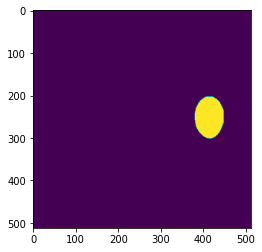

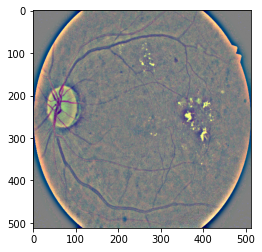

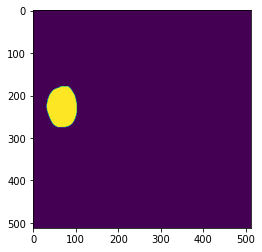

In [17]:
for i in range(0,10,5):
  plt.imshow(train_batch[i])
  plt.show()
  plt.imshow(np.squeeze(train_label[i],axis=2))
  plt.show()

In [21]:
data_gen_args = dict(rotation_range=60,
                     width_shift_range=1.10,
                     height_shift_range=0.05,
                     zoom_range=[0.75,1],
                     fill_mode='nearest')
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)
seed=2
image_datagen.fit(train_batch, augment=True, seed=seed)
mask_datagen.fit(train_label, augment=True, seed=seed)
image_generator = image_datagen.flow(train_batch,seed=seed,batch_size=4)
mask_generator = mask_datagen.flow(train_label,seed=seed,batch_size=4)
gen=zip(image_generator, mask_generator)

1.0 (4, 512, 512, 3)


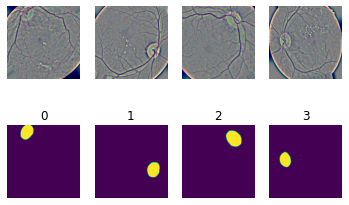

In [22]:
for i,(img,lbl) in enumerate(gen):
  print(np.max(img),img.shape)
  for j in range(4):
    ax=plt.subplot(2,4,j+1)  
    plt.imshow(img[j])
    plt.axis('off')
    #plt.figure(figsize=(6,6))
    ax=plt.subplot(2,4,j+5) 
    plt.imshow(np.squeeze(lbl[j]))
    plt.title("{}".format(j) )
    plt.axis('off')
  break

In [49]:
random.seed = seed
np.random.seed(seed)
tf.seed = seed
tf.random.set_seed(2)
depths=[2,3,4,5,6]
models=[]
histories=[]
for depth in [4]:
  opt=keras.optimizers.Adam(learning_rate = 0.001,beta_1=0.8)
  #5 layer and 3 filter have been already committed
  model = UNet_modular(depth=depth,f=4)
  model.compile(optimizer=opt, loss=dice_loss, metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])   
  early_stopping= tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta =0.001, patience=8,verbose=1)
  rlrop=tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=4,verbose=1,mode='auto', min_delta=0.01) 
  hist = model.fit(gen, steps_per_epoch=len(image_generator), epochs = 150, verbose = 1, callbacks=[early_stopping,rlrop])
  #hist = model.fit(x = train_batch, y = train_label, batch_size = 3, epochs = 150, verbose = 1, callbacks=[early_stopping], validation_split = 8/135, shuffle = True)
  models.append(model)
  histories.append(hist)

[4, 8, 16, 32]
Epoch 1/150
68/68 [==============================] - 26s 335ms/step - loss: 0.7676 - mean_io_u_6: 0.5858
Epoch 2/150
68/68 [==============================] - 22s 322ms/step - loss: 0.3904 - mean_io_u_6: 0.7358
Epoch 3/150
68/68 [==============================] - 22s 319ms/step - loss: 0.1234 - mean_io_u_6: 0.8964
Epoch 4/150
68/68 [==============================] - 22s 322ms/step - loss: 0.1118 - mean_io_u_6: 0.9111
Epoch 5/150
68/68 [==============================] - 22s 321ms/step - loss: 0.0957 - mean_io_u_6: 0.9046
Epoch 6/150
68/68 [==============================] - 22s 321ms/step - loss: 0.1053 - mean_io_u_6: 0.8986
Epoch 7/150
68/68 [==============================] - 22s 326ms/step - loss: 0.0669 - mean_io_u_6: 0.9332
Epoch 8/150
68/68 [==============================] - 22s 324ms/step - loss: 0.0756 - mean_io_u_6: 0.9218
Epoch 9/150
68/68 [==============================] - 22s 321ms/step - loss: 0.0900 - mean_io_u_6: 0.9166
Epoch 10/150
68/68 [====================

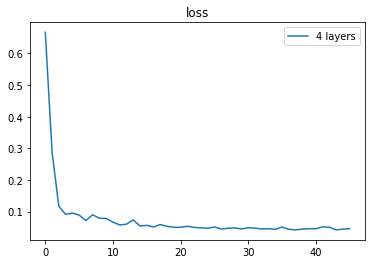

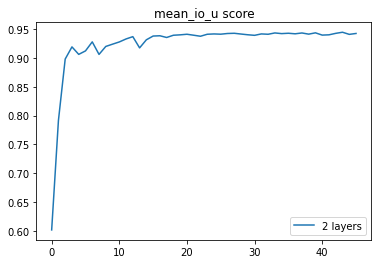

In [50]:
for i,hist in enumerate(histories):
  plt.plot(hist.history['loss'],label="{} layers".format(2+2))
plt.legend()
plt.title('loss')
plt.show()
for i,hist in enumerate(histories):
  plt.plot(hist.history['mean_io_u_{}'.format(str(6+i))],label="{} layers".format(i+2))
plt.legend()
plt.title('mean_io_u score')
plt.show()

## prediction


In [51]:
predicted_test_label=np.zeros(test_label.shape)
for i in range(27):
  #print(np.expand_dims(test_batch[i],axis=0).shape)
  predicted_test_label[i]=models[0].predict(np.expand_dims(test_batch[i],axis=0)) 

(512, 512, 1)


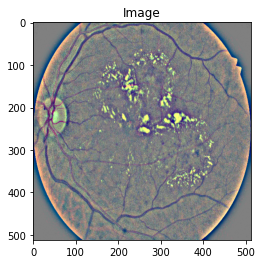

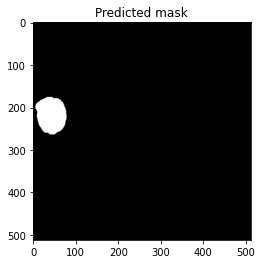

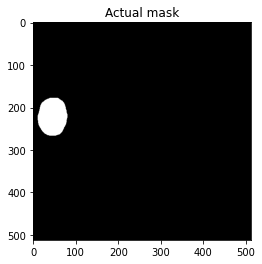

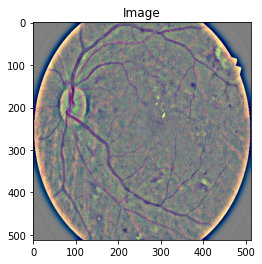

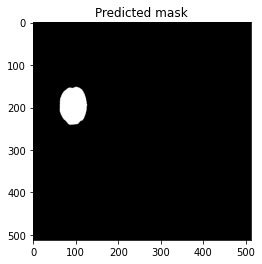

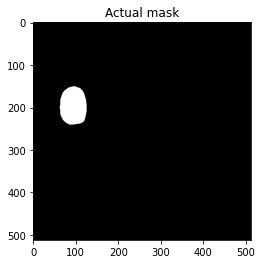

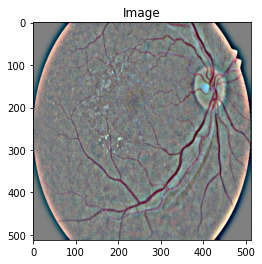

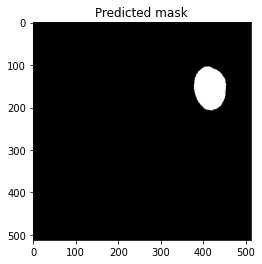

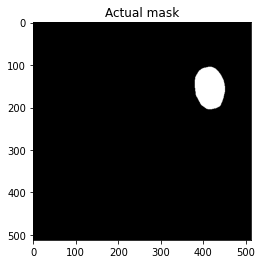

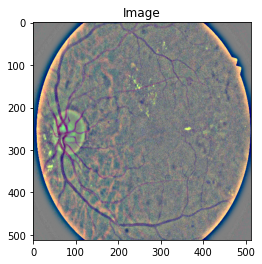

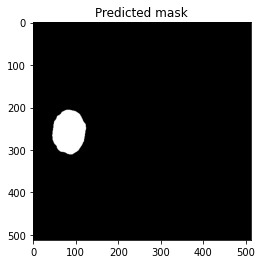

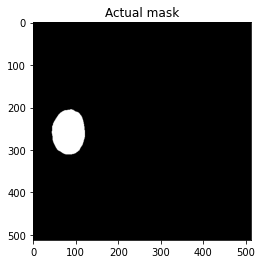

In [52]:
# predicted_test_label=models[0].predict(test_batch)
print(predicted_test_label[0].shape)
for i in range(4):
    plt.imshow(test_batch[i,:,:,:])
    plt.title("Image")
    plt.show()  
    plt.imshow(np.squeeze(predicted_test_label[i,:,:,:], axis = 2),cmap='gray')
    plt.title("Predicted mask")
    plt.show()
    plt.imshow(np.squeeze(test_label[i,:,:,:], axis = 2), cmap='gray')
    plt.title("Actual mask")
    plt.show()

In [53]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score,jaccard_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

5 layers
jaccard_score train  0  test  0.9202493963127164
Train  F1 score: 0.000000 Test F1 score: 0.958469
train AUPR 0  test AUPR 0.9548044807903545


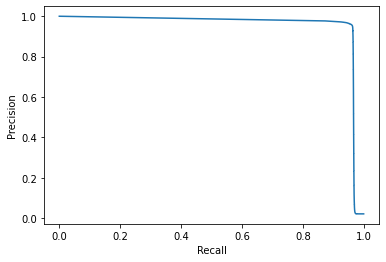

In [56]:
for i,model in enumerate(models):
  print(5, "layers")
  #generate the masks
   
  # ROC
  test_auc = jaccard_score(np.round(test_label.reshape(-1)),np.round(predicted_test_label.reshape(-1)))
  #train_auc = roc_auc_score(train_label.reshape(-1),predicted_train_label.reshape(-1))
  print("jaccard_score","train ",0," test ",test_auc)

  # F1
  testy, yhat_classes=(test_label.reshape(-1),np.round(predicted_test_label.reshape(-1)))
  test_f1 = f1_score(testy, yhat_classes)
  #testy, yhat_classes=train_label.reshape(-1),np.round(predicted_train_label.reshape(-1))
  #train_f1 = f1_score(testy, yhat_classes)
  train_f1=0
  print('Train  F1 score: %f' % train_f1,'Test F1 score: %f' % test_f1)

  #AUPR
  test_aupr = precision_recall_curve(test_label.reshape(-1),predicted_test_label.reshape(-1))
  #train_aupr = precision_recall_curve(train_label.reshape(-1),predicted_train_label.reshape(-1))
  #train_auc=auc(train_aupr[1],train_aupr[0] )
  train_auc=0
  test_auc=auc(test_aupr[1],test_aupr[0] )
  print("train AUPR",train_auc," test AUPR",test_auc)
  
  #plot Precision recall curve
  plt.plot(test_aupr[1],test_aupr[0])
  plt.ylabel('Precision')
  plt.xlabel('Recall')
  plt.show()
  #del predicted_test_label 

In [55]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/MyDrive/IDRid/Experimental models/opticdisk_ben_sigm8_4l_4f.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/MyDrive/IDRid/Experimental models/opticdisk_ben_sigm8_4l_4f.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
0# from tensorflow.keras.models import model_from_jsonn bvcx

# # load json and create model
# json_file = open('/content/drive/MyDrive/IDRid/model_EX.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)

# # load weights into new model
# loaded_model.load_weights("/content/drive/MyDrive/IDRid/model_EX.h5")
# print("Loaded model from disk")

# # evaluate loaded model on test data
# loaded_model.compile()
# print("Model loaded")

0

0

In [ ]:
# predicted_test_label=np.zeros(test_label.shape)
# for i in range(27):
#   #print(np.expand_dims(test_batch[i],axis=0).shape)
#   predicted_test_label[i]=loaded_model.predict(np.expand_dims(test_batch[i],axis=0)) 

In [ ]:
# for i in range(27):
#     name = "hard_ex_pred_label" + str(i)
#     plt.imshow(np.squeeze(predicted_test_label[i,:,:,:], axis = 2),cmap='gray')
#     # plt.show()
#     plt.savefig(("/content/drive/MyDrive/IDRid/" + name + ".png"))